# Convolutional Neural Network (CNN)
- recognize the digit using pixel value
- use PyTorch

## Import the libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
# from tqdm.notebook import trange, tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# use cuda to accelerate the computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import datasets

In [3]:
df_train = pd.DataFrame(pd.read_csv('train.csv'))
df_test = pd.DataFrame(pd.read_csv('test.csv'))

In [4]:
df_train.head(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Understand and visualize the dataset

### The unique digit in the dataset

In [5]:
unique_values = df_train['label'].unique()
unique_values.sort()
print(unique_values)

[0 1 2 3 4 5 6 7 8 9]


### The distribution of the label in the dataset
- the distribution is roughly uniform

<AxesSubplot:ylabel='Frequency'>

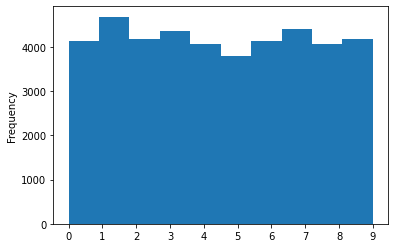

In [6]:
df_train['label'].plot.hist(bins=10, xticks=unique_values)

In [7]:
df_train.value_counts('label')

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
dtype: int64

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
y = df_train['label']
X = df_train.drop('label', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Use MinMaxScaler to normalize data
- the digit label doesn't need to be normalized since it's the target class
- normalize the pixel values

In [10]:
scaler = MinMaxScaler()
# reference: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
# the fit_transform method always used on training data
# the purpose is to calculate the mean and variance of each of the features
X_train = scaler.fit_transform(X_train)
# the transform method uses the calculated mean and variance
# to transform the test data

# the label doesn't need to be normalized -> it's the digit class
X_test = scaler.fit_transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((33600, 784), (8400, 784), (33600,), (8400,))

## Following the tutorial
reference: https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [12]:
class ClassifierDataset(Dataset):
  def __init__(self, X_data, y_data):
    super(ClassifierDataset, self).__init__()
    self.X_data = X_data
    self.y_data = y_data
      
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
      
  def __len__ (self):
    return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

## Define and optimize the model
- specify the parameters
- specify optimization model and learning rate
- see whether more layers or nodes per layer improve the performance
  - reference: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

In [13]:
# TODO: tune the parameters
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns) # the optimal size of the hidden layer is between the features and the classes
NUM_CLASSES = 10

In [14]:
# training loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader

In [15]:
# validation loader
val_loader = DataLoader(dataset=val_dataset, batch_size=1)

### Simple 3-layer feed-forward network
- with drop and batch-norm

In [16]:
class MulticlassClassification(nn.Module):
    """ The simple three layer multi-classification class
    
    """
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [17]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Specify the optimizer

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### The model description

In [19]:
print(model)

MulticlassClassification(
  (layer_1): Linear(in_features=784, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training the model

In [20]:
def multi_acc(y_pred, y_test):
  y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
  _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
  
  correct_pred = (y_pred_tags == y_test).float()
  acc = correct_pred.sum() / len(correct_pred)
  
  acc = torch.round(acc * 100)
  
  return acc

In [21]:
accuracy_stats = {
  'train': [],
  "val": []
}
loss_stats = {
  'train': [],
  "val": []
}

In [22]:
# reference: https://stackoverflow.com/questions/54374935/how-to-fix-this-strange-error-runtimeerror-cuda-error-out-of-memory
import gc
gc.collect()

torch.cuda.empty_cache()

In [23]:
for e in tqdm(range(1, EPOCHS+1)):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

  3%|▎         | 1/30 [00:36<17:44, 36.71s/it]

Epoch 001: | Train Loss: 0.38350 | Val Loss: 0.12555 | Train Acc: 90.647| Val Acc: 96.214


  7%|▋         | 2/30 [01:06<15:11, 32.54s/it]

Epoch 002: | Train Loss: 0.16983 | Val Loss: 0.11032 | Train Acc: 95.252| Val Acc: 96.619


 10%|█         | 3/30 [01:34<13:45, 30.58s/it]

Epoch 003: | Train Loss: 0.12796 | Val Loss: 0.09303 | Train Acc: 96.392| Val Acc: 97.167


 13%|█▎        | 4/30 [02:08<13:49, 31.90s/it]

Epoch 004: | Train Loss: 0.10092 | Val Loss: 0.08505 | Train Acc: 97.092| Val Acc: 97.310


 17%|█▋        | 5/30 [02:37<12:47, 30.71s/it]

Epoch 005: | Train Loss: 0.09029 | Val Loss: 0.08199 | Train Acc: 97.343| Val Acc: 97.417


 20%|██        | 6/30 [02:59<11:08, 27.87s/it]

Epoch 006: | Train Loss: 0.08055 | Val Loss: 0.07543 | Train Acc: 97.652| Val Acc: 97.583


 23%|██▎       | 7/30 [03:23<10:09, 26.52s/it]

Epoch 007: | Train Loss: 0.06482 | Val Loss: 0.07104 | Train Acc: 98.083| Val Acc: 97.726


 27%|██▋       | 8/30 [03:55<10:26, 28.49s/it]

Epoch 008: | Train Loss: 0.05997 | Val Loss: 0.08074 | Train Acc: 98.238| Val Acc: 97.810


 30%|███       | 9/30 [04:24<09:57, 28.44s/it]

Epoch 009: | Train Loss: 0.05319 | Val Loss: 0.08261 | Train Acc: 98.407| Val Acc: 97.655


 33%|███▎      | 10/30 [04:53<09:36, 28.81s/it]

Epoch 010: | Train Loss: 0.05337 | Val Loss: 0.07566 | Train Acc: 98.393| Val Acc: 97.786


 37%|███▋      | 11/30 [05:18<08:40, 27.40s/it]

Epoch 011: | Train Loss: 0.04832 | Val Loss: 0.07687 | Train Acc: 98.517| Val Acc: 97.738


 40%|████      | 12/30 [05:42<07:57, 26.53s/it]

Epoch 012: | Train Loss: 0.03955 | Val Loss: 0.08634 | Train Acc: 98.743| Val Acc: 97.726


 43%|████▎     | 13/30 [06:06<07:19, 25.84s/it]

Epoch 013: | Train Loss: 0.03791 | Val Loss: 0.07090 | Train Acc: 98.849| Val Acc: 97.798


 47%|████▋     | 14/30 [06:35<07:05, 26.59s/it]

Epoch 014: | Train Loss: 0.03599 | Val Loss: 0.07635 | Train Acc: 98.877| Val Acc: 97.726


 50%|█████     | 15/30 [06:58<06:25, 25.68s/it]

Epoch 015: | Train Loss: 0.03473 | Val Loss: 0.07979 | Train Acc: 98.920| Val Acc: 97.786


 53%|█████▎    | 16/30 [07:27<06:11, 26.54s/it]

Epoch 016: | Train Loss: 0.02904 | Val Loss: 0.07932 | Train Acc: 99.120| Val Acc: 98.000


 57%|█████▋    | 17/30 [07:50<05:32, 25.59s/it]

Epoch 017: | Train Loss: 0.03115 | Val Loss: 0.07433 | Train Acc: 99.057| Val Acc: 97.881


 60%|██████    | 18/30 [08:12<04:55, 24.59s/it]

Epoch 018: | Train Loss: 0.02798 | Val Loss: 0.08718 | Train Acc: 99.129| Val Acc: 97.571


 63%|██████▎   | 19/30 [08:35<04:22, 23.90s/it]

Epoch 019: | Train Loss: 0.02963 | Val Loss: 0.07972 | Train Acc: 99.071| Val Acc: 97.952


 67%|██████▋   | 20/30 [09:03<04:11, 25.12s/it]

Epoch 020: | Train Loss: 0.02546 | Val Loss: 0.08313 | Train Acc: 99.226| Val Acc: 97.857


 70%|███████   | 21/30 [09:30<03:50, 25.66s/it]

Epoch 021: | Train Loss: 0.02186 | Val Loss: 0.09127 | Train Acc: 99.309| Val Acc: 97.702


 73%|███████▎  | 22/30 [09:52<03:18, 24.77s/it]

Epoch 022: | Train Loss: 0.02500 | Val Loss: 0.07382 | Train Acc: 99.291| Val Acc: 98.024


 77%|███████▋  | 23/30 [10:15<02:48, 24.04s/it]

Epoch 023: | Train Loss: 0.02336 | Val Loss: 0.07913 | Train Acc: 99.308| Val Acc: 97.976


 80%|████████  | 24/30 [10:37<02:22, 23.68s/it]

Epoch 024: | Train Loss: 0.02183 | Val Loss: 0.08113 | Train Acc: 99.311| Val Acc: 97.917


 83%|████████▎ | 25/30 [11:00<01:56, 23.38s/it]

Epoch 025: | Train Loss: 0.02095 | Val Loss: 0.08448 | Train Acc: 99.343| Val Acc: 97.905


 87%|████████▋ | 26/30 [11:23<01:33, 23.37s/it]

Epoch 026: | Train Loss: 0.02043 | Val Loss: 0.07893 | Train Acc: 99.394| Val Acc: 97.917


 90%|█████████ | 27/30 [11:47<01:10, 23.49s/it]

Epoch 027: | Train Loss: 0.01963 | Val Loss: 0.07985 | Train Acc: 99.397| Val Acc: 98.000


 93%|█████████▎| 28/30 [12:11<00:47, 23.52s/it]

Epoch 028: | Train Loss: 0.02258 | Val Loss: 0.07963 | Train Acc: 99.308| Val Acc: 98.012


 97%|█████████▋| 29/30 [12:41<00:25, 25.50s/it]

Epoch 029: | Train Loss: 0.01545 | Val Loss: 0.08621 | Train Acc: 99.554| Val Acc: 98.048


100%|██████████| 30/30 [13:06<00:00, 26.22s/it]

Epoch 030: | Train Loss: 0.01838 | Val Loss: 0.08060 | Train Acc: 99.406| Val Acc: 98.012


Text(0.5, 1.0, 'Train-Validation Loss/Epoch')

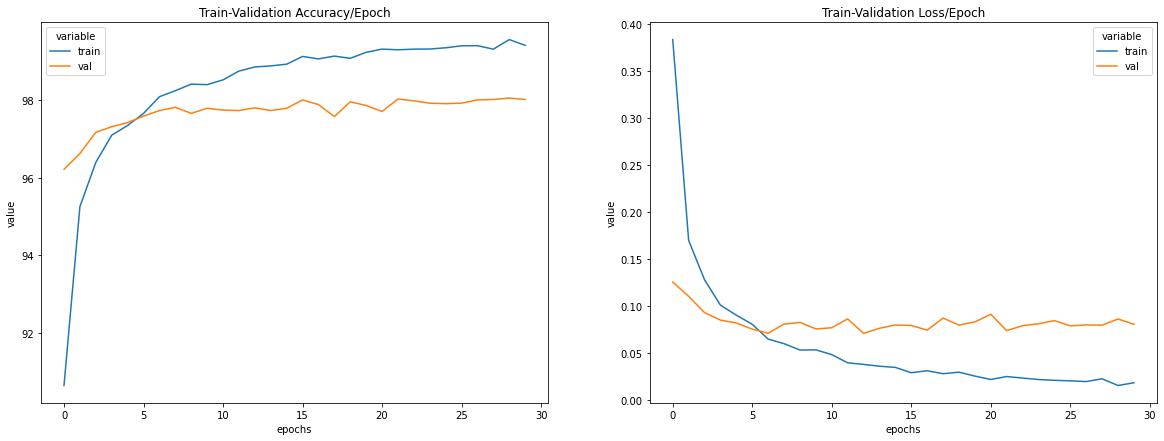

In [24]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Validation Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Validation Loss/Epoch')